# Präsenzversuch zum Laval-Rotor

Name:  Noah Waltmann
Datum:  6.2.2024
Gruppe: 13

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Was für Erkenntnisse kann man aus der Schwingungsanalyse eines Lavallrotors erhalten. Welchen Einfluss haben unterschiedliche geometrische Eigenschaften auf das Schwingverhalten.

## Erster Versuch: Prüfstand 4
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="figures/IMG_8432.jpg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:
Aufbau des Prüfstandes:
Masse der Scheibe: 1000 g
Art der Lagerung: Pendelrollenlager
Abstand der Lagerung: 0.75 m 
Durchmesser der Welle: 8 mm

Eine Scheibe ist mitttig auf einer Welle montiert. Die Welle ist mit zwei Kegelrollenlagen gelagert(gleicher abstand zur Scheibe bzw. Wellenmitte)

Die Welle wird mit verschiedenen Drehzahlen angeregt wobei die Schwingung, die aufgrund der Unwucht ausgelöst wird, mit einem Beschleunigungssensor gemessen. 

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240117_154512_lavalrotor_13_04"
)  # path to the folder with H5-file and metadata
filename = "data_20240117_154512_lavalrotor_13_04.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [5]:
time=[]
accel_value=[]
accel_interp=[]
rpm=[]
amplitude=[]
frequency=[]

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
importlib.reload(m_postprocessing)  # reload functions

#pfad erstellen
hdf_path = path_measurement_folder + "/" + filename

with h5py.File(hdf_path) as f:
    # Durchlaufen der verschiedenen Drehzahlen
    for i in f.keys():
        
        # extracting acceleration from h5 file 
        a_x_rpm = np.array(f[i]["RawData"][uuid_acceleration]["acceleration_x"])
        a_y_rpm = np.array(f[i]["RawData"][uuid_acceleration]["acceleration_y"])
        a_z_rpm = np.array(f[i]["RawData"][uuid_acceleration]["acceleration_z"])
        
        # appending time , rpm and acceleration to lists 
        time_rpm=np.array(f[i]["RawData"][uuid_acceleration]["timestamp"])
        time.append(time_rpm)
        
        rpm_rpm=(f[i]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
        rpm.append(rpm_rpm)
        
        accel_value_rpm = m_postprocessing.get_vec_accel(a_x_rpm,a_y_rpm,a_z_rpm)
        #accel_value.append(accel_value_rpm)
        
        # interpolating the data
        accel_interp_rpm = m_postprocessing.interpolation(time_rpm,accel_value_rpm,interpolation_points)
        #accel_interp.append(accel_interp_rpm)
        
        # scaled fft for measurement data
        [scaled_ampl_rpm,freq_rpm]= m_postprocessing.my_fft_scaled(accel_interp_rpm,interpolation_points)
        amplitude.append(scaled_ampl_rpm)
        frequency.append(freq_rpm)
        

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

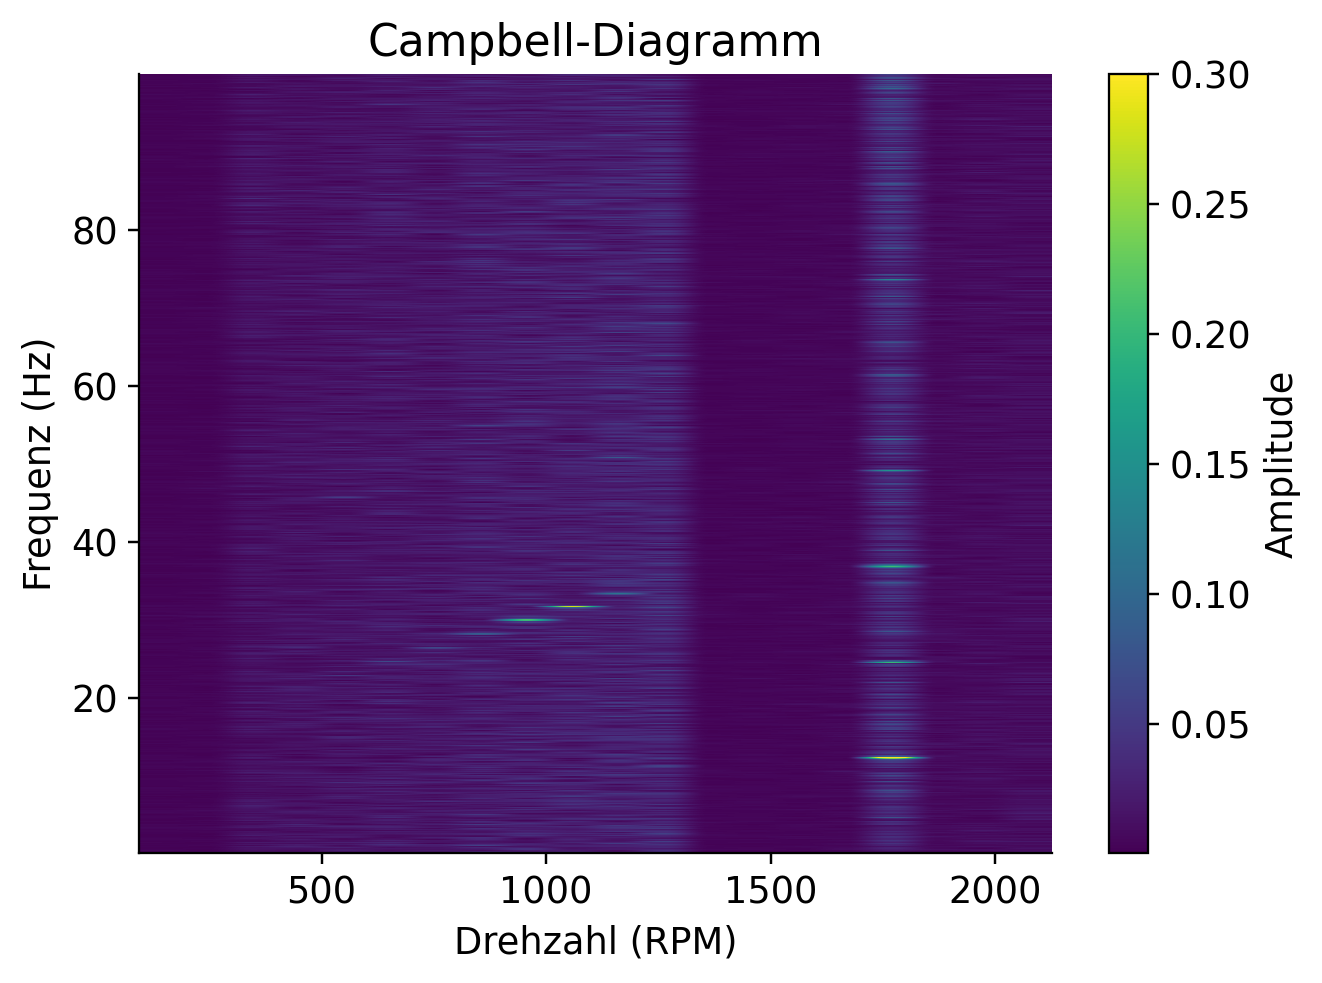

In [7]:
#plt.imshow(amplitude, extent=[np.min(frequency), np.max(frequency), np.min(rpm), np.max(rpm)],
#           aspect='auto', cmap='viridis', origin='lower')

#plt.colorbar(label='Amplitude')  # Farbskala für Amplituden
#plt.xlabel('Frequenz (Hz)')
#plt.ylabel('Drehzahl (RPM)')
#plt.title('Campbell-Diagramm')
#plt.show()

plt.imshow(np.transpose(amplitude),extent=[np.min(rpm), np.max(rpm), np.min(frequency), np.max(frequency)],
           aspect='auto', cmap='viridis', origin='lower',vmax=0.3)

plt.colorbar(label='Amplitude')  # Farbskala für Amplituden
plt.ylabel('Frequenz (Hz)')
plt.xlabel('Drehzahl (RPM)')
plt.title('Campbell-Diagramm')
plt.show()

## Zweiter Datensatz: Prüfstand 2

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_100928_lavalrotor_01_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_100928_lavalrotor_01_02.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

time=[]
accel_value=[]
accel_interp=[]
rpm=[]
amplitude=[]
frequency=[]


#### 2. Verarbeitung der Messdaten

In [9]:
importlib.reload(m_postprocessing)  # reload functions

#pfad erstellen
hdf_path = path_measurement_folder + "/" + filename

with h5py.File(hdf_path) as f:
    # Durchlaufen der verschiedenen Drehzahlen
    for i in f.keys():
        
        # extracting acceleration from h5 file 
        a_x_rpm = np.array(f[i]["RawData"][uuid_acceleration]["acceleration_x"])
        a_y_rpm = np.array(f[i]["RawData"][uuid_acceleration]["acceleration_y"])
        a_z_rpm = np.array(f[i]["RawData"][uuid_acceleration]["acceleration_z"])
        
        # appending time , rpm and acceleration to lists 
        time_rpm=np.array(f[i]["RawData"][uuid_acceleration]["timestamp"])
        time.append(time_rpm)
        
        rpm_rpm=np.array(f[i]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
        rpm.append(rpm_rpm)
        
        accel_value_rpm = m_postprocessing.get_vec_accel(a_x_rpm,a_y_rpm,a_z_rpm)
        accel_value.append(accel_value_rpm)
        
        # interpolating the data
        accel_interp_rpm = m_postprocessing.interpolation(time_rpm,accel_value_rpm,interpolation_points)
        accel_interp.append(accel_interp_rpm)
        
        # scaled fft for measurement data
        [scaled_ampl_rpm,freq_rpm]= m_postprocessing.my_fft_scaled(accel_interp_rpm,interpolation_points)
        amplitude.append(scaled_ampl_rpm)
        frequency.append(freq_rpm)


#### 3. Darstellung mittels Campbell-Diagramm

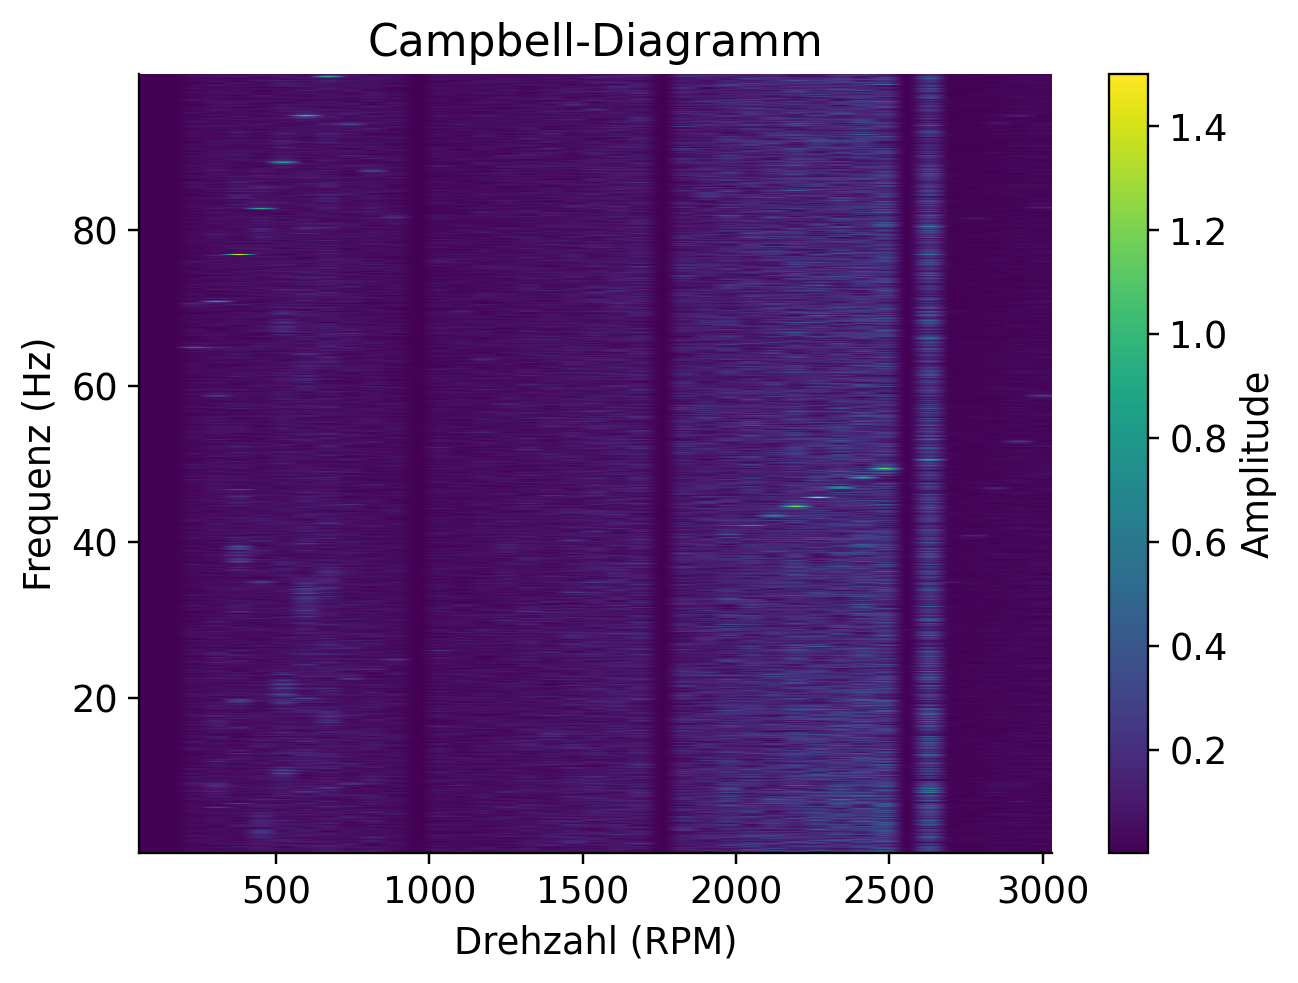

In [10]:
plt.imshow(np.transpose(amplitude), extent=[np.min(rpm), np.max(rpm), np.min(frequency), np.max(frequency)],
           aspect='auto', cmap='viridis', origin='lower',vmax=1.5)

plt.colorbar(label='Amplitude')  # Farbskala für Amplituden
plt.ylabel('Frequenz (Hz)')
plt.xlabel('Drehzahl (RPM)')
plt.title('Campbell-Diagramm')
plt.show()

## Dritter Datensatz: Prüfstand 3

#### 1. Einlesen der Mess- und Metadaten

In [11]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
#print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

time=[]
accel_value=[]
accel_interp=[]
rpm=[]
amplitude=[]
frequency=[]


#### 2. Verarbeitung der Messdaten

In [12]:
importlib.reload(m_postprocessing)  # reload functions

#pfad erstellen
hdf_path = path_measurement_folder + "/" + filename

with h5py.File(hdf_path) as f:
    # Durchlaufen der verschiedenen Drehzahlen
    for i in f.keys():
        
        # extracting acceleration from h5 file 
        a_x_rpm = np.array(f[i]["RawData"][uuid_acceleration]["acceleration_x"])
        a_y_rpm = np.array(f[i]["RawData"][uuid_acceleration]["acceleration_y"])
        a_z_rpm = np.array(f[i]["RawData"][uuid_acceleration]["acceleration_z"])
        
        # appending time , rpm and acceleration to lists 
        time_rpm=np.array(f[i]["RawData"][uuid_acceleration]["timestamp"])
        time.append(time_rpm)
        
        rpm_rpm=np.array(f[i]["RawData"][uuid_motor_rpm]["motor_rpm"][()])
        rpm.append(rpm_rpm)
        
        accel_value_rpm = m_postprocessing.get_vec_accel(a_x_rpm,a_y_rpm,a_z_rpm)
        accel_value.append(accel_value_rpm)
        
        # interpolating the data
        accel_interp_rpm = m_postprocessing.interpolation(time_rpm,accel_value_rpm,interpolation_points)
        accel_interp.append(accel_interp_rpm)
        
        # scaled fft for measurement data
        [scaled_ampl_rpm,freq_rpm]= m_postprocessing.my_fft_scaled(accel_interp_rpm,interpolation_points)
        amplitude.append(scaled_ampl_rpm)
        frequency.append(freq_rpm)

#### 3. Darstellung mittels Campbell-Diagramm

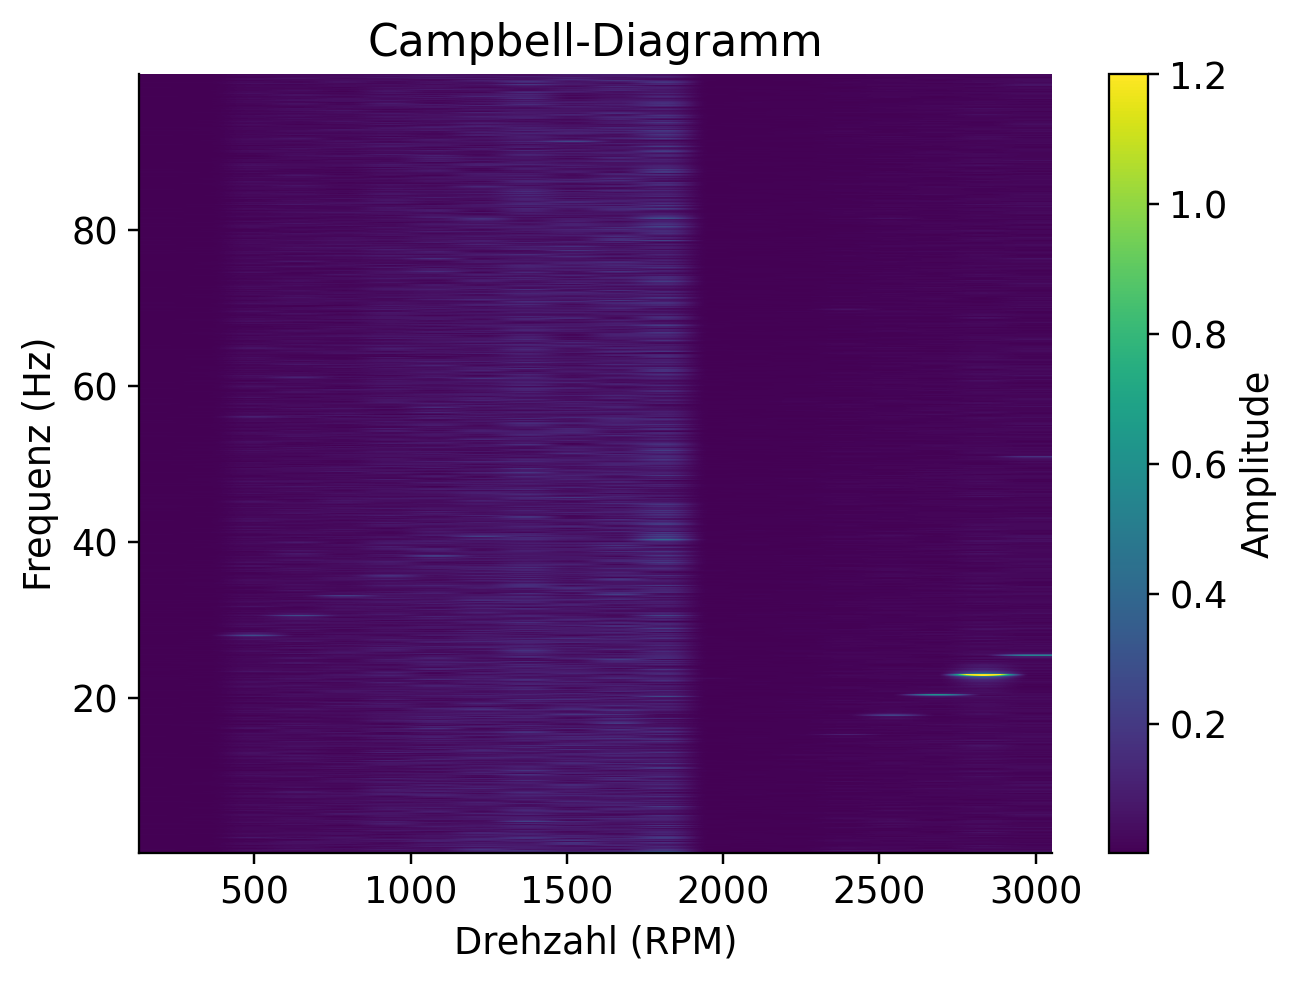

In [13]:
plt.imshow(np.transpose(amplitude), extent=[np.min(rpm), np.max(rpm), np.min(frequency), np.max(frequency)],
           aspect='auto', cmap='viridis', origin='lower',vmax=1.2)

plt.colorbar(label='Amplitude')  # Farbskala für Amplituden
plt.ylabel('Frequenz (Hz)')
plt.xlabel('Drehzahl (RPM)')
plt.title('Campbell-Diagramm')
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Mit der Schwingungsanalyse des Lavalrotors lassen sich kritische Drehzahlbereiche und stabile Drehzahlbereiche (sinnvoller Weise Betriebsbereiche) erfassen. Außerdem sind die zur Drehzahl proportionalen Schwingungsanregungen erkennbar.

Prüfstand 4:
Kritische Bereich: von 200 rpm bis 1350 rpm und von 1700 rpm bis 1750 rpm
Stabiler Bereich von 1350 rpm bis 1700 rpm und ab 1750 rpm 

Selbstzentrierung bei 1350 rpm bis 1700 rpm

Prüfstand 3:
Kritischer Bereich: von 500 rpm bis 1900 rpm
Stabiler Bereich: ab 1900 rpm

Selbstzentrierung bei 1900 rpm

Prüfstand 2: 
Kritischer Bereich:200 rpm bis 2650 rpm 
Unterbrochen durch mehrere stabile Bereiche bei:
900 rpm bis 1000 rpm, 1750 rpm bis 1800 rpm, 2550 rpm bis 2600 rpm

Selbstzentrierung 900 rpm bis 1000 rpm, 1750 rpm bis 1800 rpm, 2550 rpm bis 2600 rpm

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

<img src="figures/Aufgabenstellung_Labor_Laval_Rotor-1-3.JPG" width="500">

Die berechnete kritische Drehzahl von 458 rpm liegt innerhalb des im Campbell Diagramms erkennbaren kritischen Bereichs.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Der Versuch mit dem Lavalrotor war für mich äußerset lehrreich. Mir wurde mit dem Campell Diagramm ein mächtiges Tool an die Hand gegeben um Aussagen über mögliche Betriebsbereiche und kritische Drehzahlbereiche eines Systems mit rotierenden Bauteilen zu treffen. Ich werde mich bei zukünftigen Aufgaben an diesen Versuch zurückerinnern und auf mein gelerntes Wissen zurückgreifen können.